In [1]:
#集成学习
#概率质量函数，实现集成错误率

from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier-k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [2]:
er = ensemble_error(n_classifier=11, error=0.25)
print(er)

0.03432750701904297


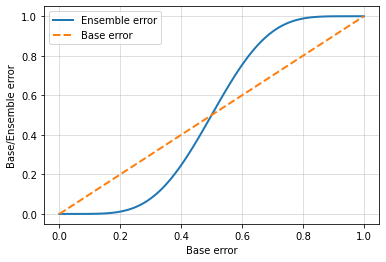

In [3]:
#计算从0.0到1.0范围内的不同集成错误率并绘制

import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [4]:
#实现基于分类概率的加权多数票分类方法
ex = np.array([[0.9,0.1], [0.8,0.2], [0.4,0.6]])
p = np.average(ex, axis=0, weights=[0.2,0.2,0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [5]:
#实现多数票机制的简单集成分类器

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """多数票集成分类器"""
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """拟合训练器"""
        #保证分类标签开始
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """预测X的类型标签"""
        if self.vote == 'probability':
            mj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            #初始化集成器的标签为classlabel
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Predict class probabilities for X"""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """访问集成分类器中每个成员分类器的参数"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in\
                six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
            return out

In [6]:
#选择数据集,预处理数据
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [7]:
#使用训练集训练三种不同分类器：逻辑回归，决策树，K-近邻

#先对训练集进行10次交叉验证以评估每个分类器模型的性能
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [8]:
#使用集成独立的分类器进行多数票决策
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.15) [Logistic regression]
Accuracy: 0.87 (+/- 0.18) [Decision tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


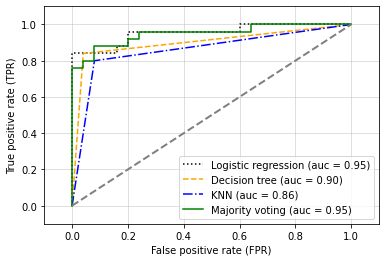

In [9]:
#基于测试数据来计算ROC曲线以检查集成器对未见过的数据是否泛化良好。
#注意测试集不会用于模型选择，其目的是报告分类器的泛化性能的无偏估计
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black','orange','blue','green']
linestyle = [':', '--', '-.', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyle):
    #假设正类标签为1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

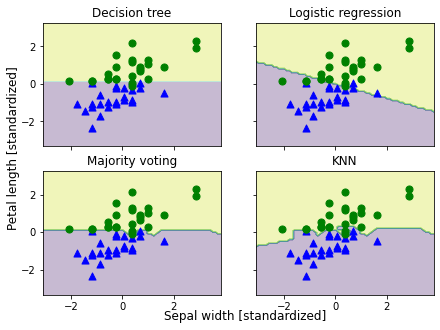

In [10]:
#可视化集成分类器的决策区域

from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:,0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1), np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
for idx,clf,tt in zip(product([0,1],[1,0]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx,yy,z,alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [11]:
print(mv_clf.get_params())

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', LogisticRegression(C=0.001, random_state=1)]]), 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0), 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', KNeighborsClassifier(n_neighbors=1)]]), 'pipeline-1__memory': None, 'pipeline-1__steps': [('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001, random_state=1)]], 'pipeline-1__verbose': False, 'pipeline-1__sc': StandardScaler(), 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1), 'pipeline-1__sc__copy': True, 'pipeline-1__sc__with_mean': True, 'pipeline-1__sc__with_std': True, 'pipeline-1__clf__C': 0.001, 'pipeline-1__clf__class_weight': None, 'pipeline-1__clf__dual': False, 'pipeline-1__clf__fit_intercept': True, 'pipeline-1__clf__intercept_scaling': 1, 'pipeline-1__clf__l1_ratio': None, 'pipeline-1__clf__max_iter': 100, 'pipeline-1__clf__multi_class': 'auto', '